In [1]:
import copy
import pathlib

import pandas as pd
from preprocessing.pipeline import (
    combine_data_NYPD,
    get_preprocessed_data,
    preprocess_311,
    process_crime_data,
    query_data,
)
from preprocessing.weather_parse import weather_parse


In [2]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [3]:
df["resolution_class"].value_counts()

resolution_class
resolved before police    736174
resolved by police        591522
resolution unknown         86057
failed to respond          75396
Name: count, dtype: int64[pyarrow]

In [4]:
df.dtypes

borough                                  string[pyarrow]
precinct                                 string[pyarrow]
complaint_type                           string[pyarrow]
created_H                         timestamp[ns][pyarrow]
closed_H                          timestamp[ns][pyarrow]
created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
agency                                   string[pyarrow]
descriptor                               string[pyarrow]
status                                   string[pyarrow]
resolution_description                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
due_date                          timestamp[ns][pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
hours_to_complete                        double[pyarrow]
created                                   int64[pyarrow]
created_bo                     

In [5]:
import datetime
import heapq
import json
import multiprocessing as mp
import pathlib
from dataclasses import dataclass, field
from typing import Iterable

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import CoxPHFitter, utils
from matplotlib import pyplot as plt
from preprocessing.pre_survival import prep_data_for_surv_analysis
from scipy.integrate import trapezoid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.util import Surv
from statsmodels.duration.hazard_regression import PHReg, PHRegResults
from tqdm import tqdm

In [6]:
## HYPERPARAMETERS ##
from typing import List


save_name = input(
   "Input a name for this model or leave blank to use a hash of the model results"
)

root_save_dir: pathlib.Path = pathlib.Path("../models/survival_forest/")


@dataclass
class RSFParams:
   keep_cols: List = field(default_factory=lambda: [])
   add_datetime_cols: bool = True
   year:int = year
   seed: int = 14
   strata: list = field(default_factory=lambda: ["borough"])
   target_col: str = "hours_to_complete"
   status_col: str = "resolution_class"
   datetime_col: str = "created_H"
   save_name: str = save_name
   max_depth: int = 4
   cpu_prop: float = 0.5
   remove_cols: set = field(
      default_factory=lambda: {
         "descriptor",
         "resolution_description",
         "resolution_action_updated_date",
         "incident_zip",
         "city",
         "bbl",
         "status",
         "closed_H",
         "created_date",
         "closed_date",
         "sector",
         "due_date",
         "created",
         "date_H",
         "precinct",
         # 'created',
         # 'created_bo',
         # 'created_ag',
         # 'created_co',
         # 'created_bo_ag',
         # 'open',
         # 'open_bo',
         # 'open_ag',
         # 'open_co',
         # 'open_bo_ag',
         # 'open_bo_co',
         "precip_period_hrs",
         "precip_accumulation_mm",
         "direction_deg",
         "agency",
         'latitude',
         'longitude',
         # 'created_bo_co',
         # 'temperature_c',
         # 'speed_mps',
         # 'dew_temperature_c',
      }
   )
   ohe: bool = True


hyper = RSFParams()

In [7]:
class RSFHyperEncoder(json.JSONEncoder):
    def default(self, o):
        o_dict = o.__dict__
        for k in o_dict.keys():
            v = o_dict[k]
            if isinstance(v, str):
                o_dict[k] = v
            elif isinstance(v, Iterable):
                o_dict[k] = list(v)
        return o_dict

class DefaultDecoder:
    def __init__(self, cls):
        self.cls = cls
        self.annotations = getattr(cls, '__annotations__', {})

    def __call__(self, data):
        for key, value_type in self.annotations.items():
            if key not in data:
                continue
            value = data[key]
            try:
                if not isinstance(value, value_type):
                    data[key] = value_type(value)
            except (TypeError, ValueError):
                raise TypeError(f"Value for '{key}' must be of type '{value_type.__name__}'")
        return self.cls(data)

rsf_decoder = DefaultDecoder(RSFParams)

In [8]:

assert 0 < hyper.cpu_prop <= 1
n_jobs = int(mp.cpu_count() * hyper.cpu_prop)
try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=rsf_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    rsf = joblib.load(root_save_dir / f"{save_name}" / "rsf.pickle")
    scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )

except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )

    rsf = RandomSurvivalForest(
        500,
        max_depth=hyper.max_depth,
        min_samples_leaf=50,
        n_jobs=n_jobs,
        random_state=hyper.seed,
        verbose=2
    )
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    joblib.dump(rsf, save_path / "rsf.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=RSFHyperEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   28.2s


building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67

[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  3.7min


building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500


[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  9.1min


building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500


[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed: 13.8min finished


In [9]:
chunk_size = 8000

In [10]:
def predict_surv_exp_med(sf, X_test, chunk_size):

    pm = pe = None
    mapper = pd.Series(sf.unique_times_)
    for i in range(0, X_test.shape[0], chunk_size):
        surv = sf.predict_survival_function(X_test[i:i+chunk_size], return_array=True)

        subjects = list(range(X_test[i:i+chunk_size].shape[0]))
        pred_med = utils.qth_survival_times(0.5, surv[subjects].T).T.squeeze()
        pred_med = pred_med.map(mapper)

        pred_exp = pd.Series(trapezoid(surv, sf.unique_times_))
        if pe is None:
            pe = pd.Series(pred_exp, name="expected_htc")
            pm = pd.Series(pred_med, name="med_htc")
        else:
            pe = pd.concat((pe, pred_exp))
            pm = pd.concat((pm, pred_med))

    return pe, pm

pred_exp, pred_med = predict_surv_exp_med(rsf, X_test, chunk_size)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:  6.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  4.3min
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:  6.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed: 

In [11]:
gt = pd.Series([y[1] for y in y_test], name="hours_to_complete")

In [15]:
pred_exp.reset_index(drop=True)

0          6.980407
1          6.859251
2          8.403882
3          6.711772
4         11.577068
            ...    
148066     7.216451
148067    12.613935
148068     9.451535
148069     9.154550
148070     8.421572
Length: 148071, dtype: float64

In [18]:
final_df = pd.concat([X_test.reset_index(), gt, pred_exp.reset_index(drop=True), pred_med.reset_index(drop=True)], axis=1)
final_df["expected_htc"] = final_df[0]
final_df["med_htc"] = final_df[1]

Text(0.5, 1.0, 'Predicted vs True Time to Close Complaint in Hours')

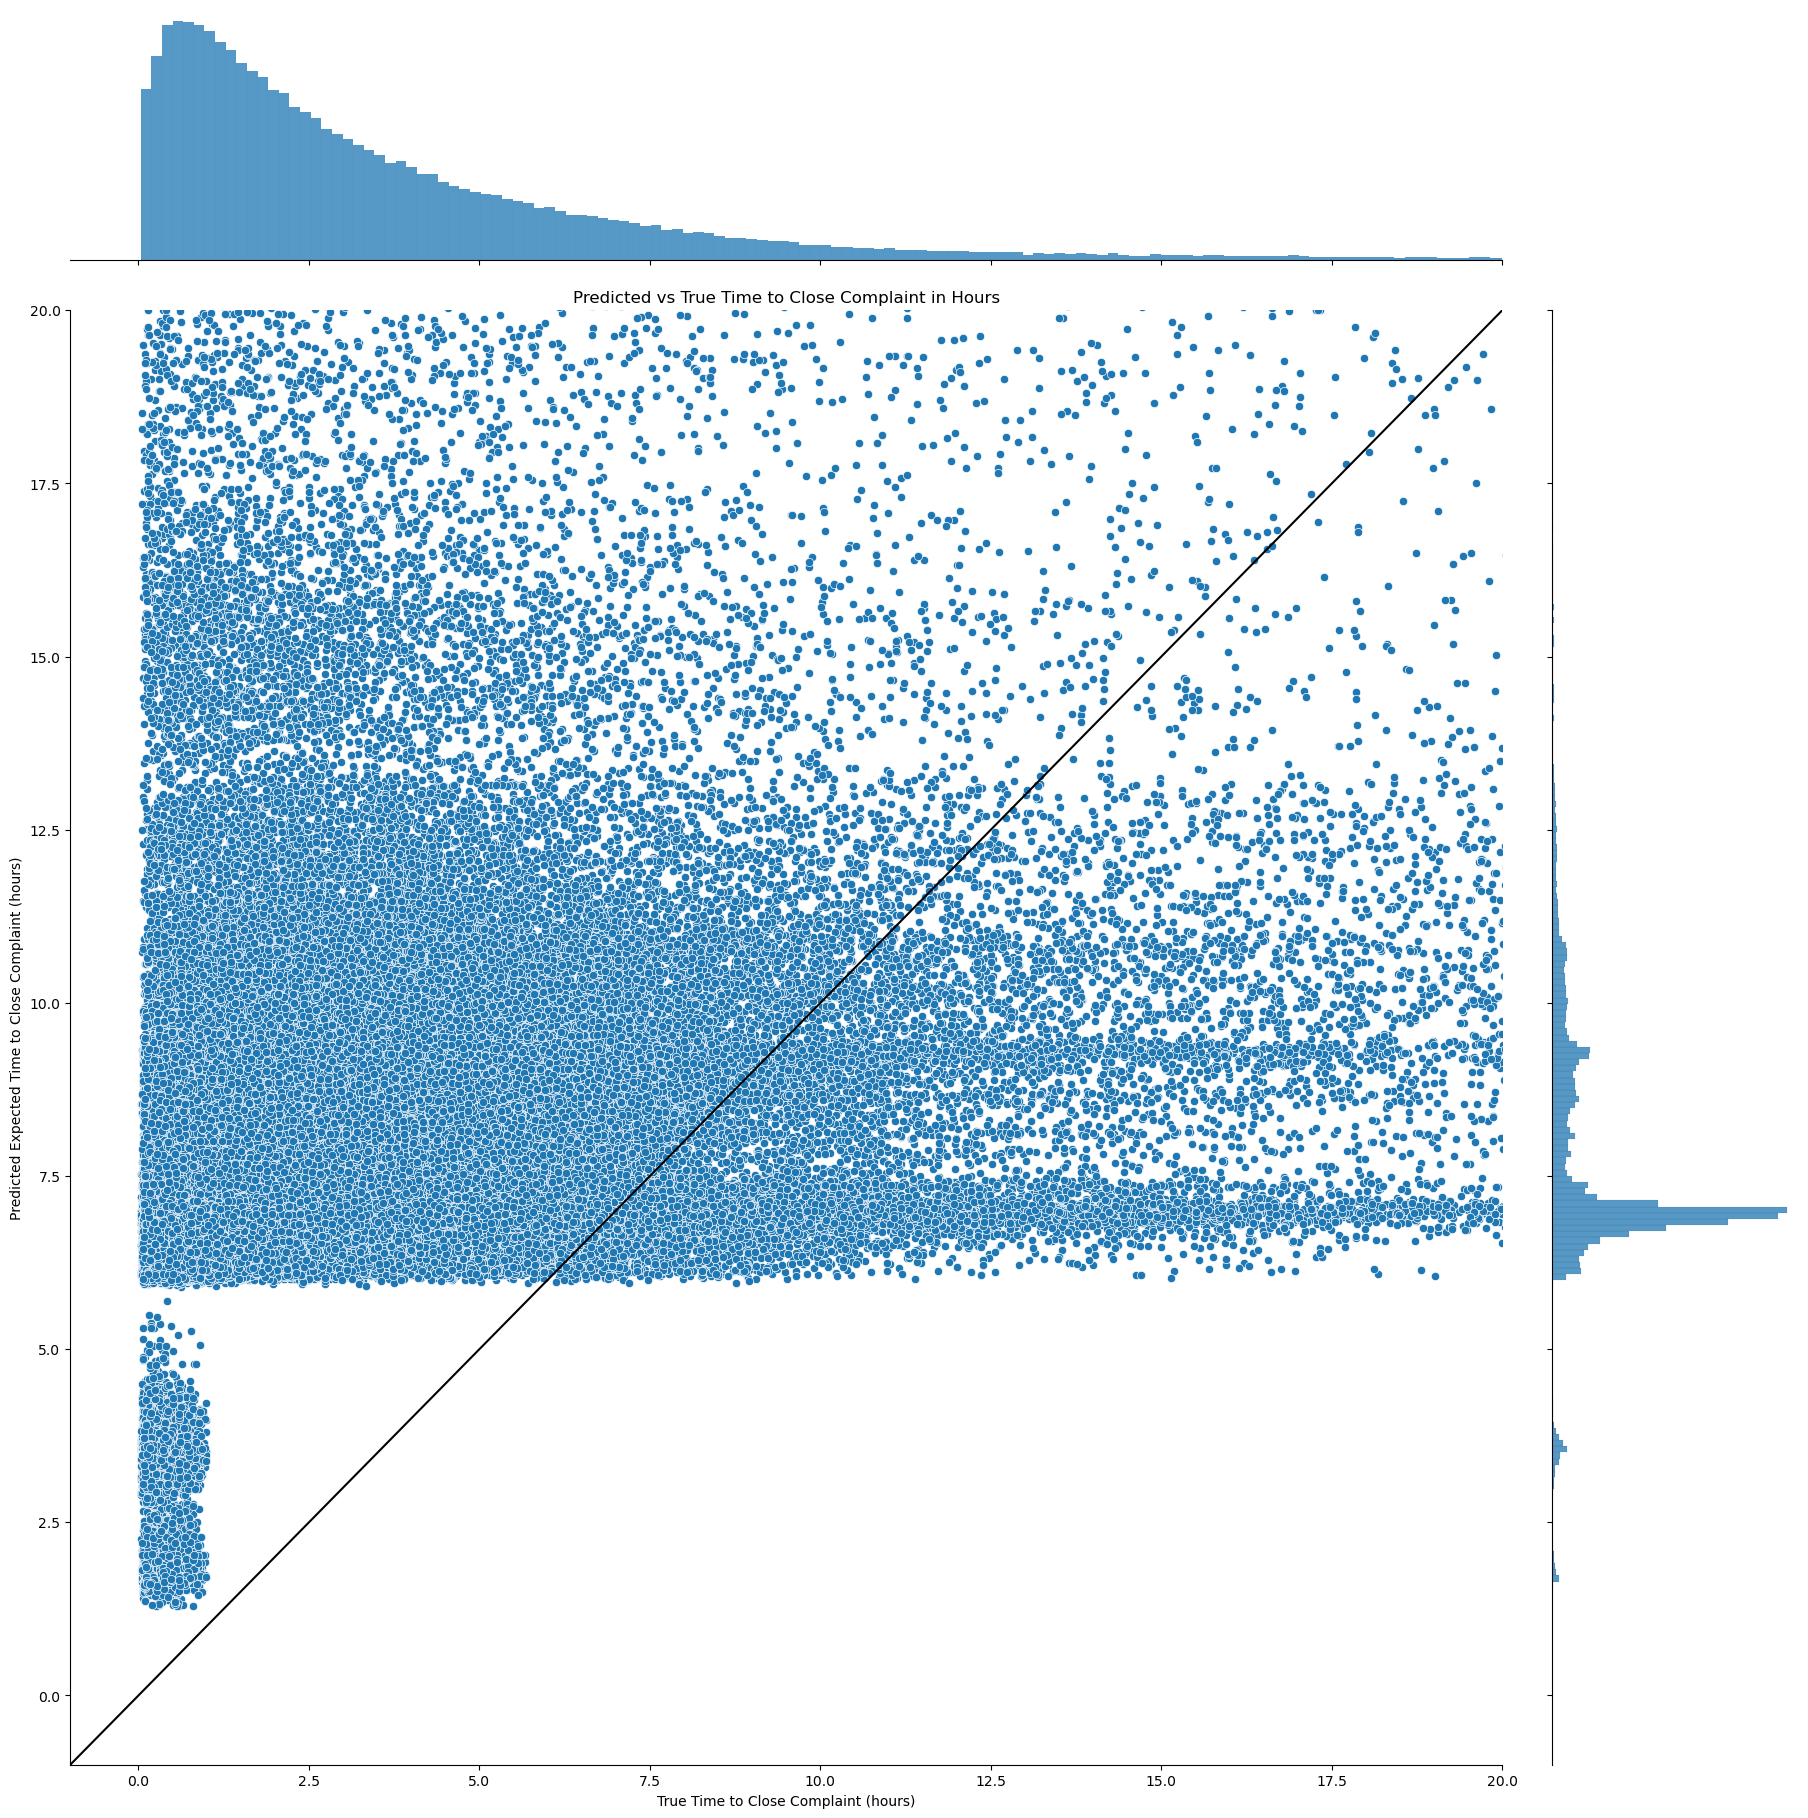

In [19]:
import seaborn as sns
# Define a color palette for different complaint types
palette = sns.color_palette("husl", len(df['complaint_type'].unique()))

# Create a scatter plot with Seaborn
jg = sns.jointplot(data=final_df, x='hours_to_complete', y='expected_htc',)
ax = jg.ax_joint
# Show the plot
ax.set_ylim(-1, 20)
ax.set_xlim(ax.get_ylim())
plt.plot([-10,100],[-10,100], color='k')
fig = ax.get_figure()
fig.set_size_inches((20,20))
# ax.legend(bbox_to_anchor=[1,0.55])
ax.set_xlabel('True Time to Close Complaint (hours)')
ax.set_ylabel('Predicted Expected Time to Close Complaint (hours)')
ax.set_title('Predicted vs True Time to Close Complaint in Hours')

Text(0.5, 1.0, 'Predicted vs True Time to Close Complaint in Hours')

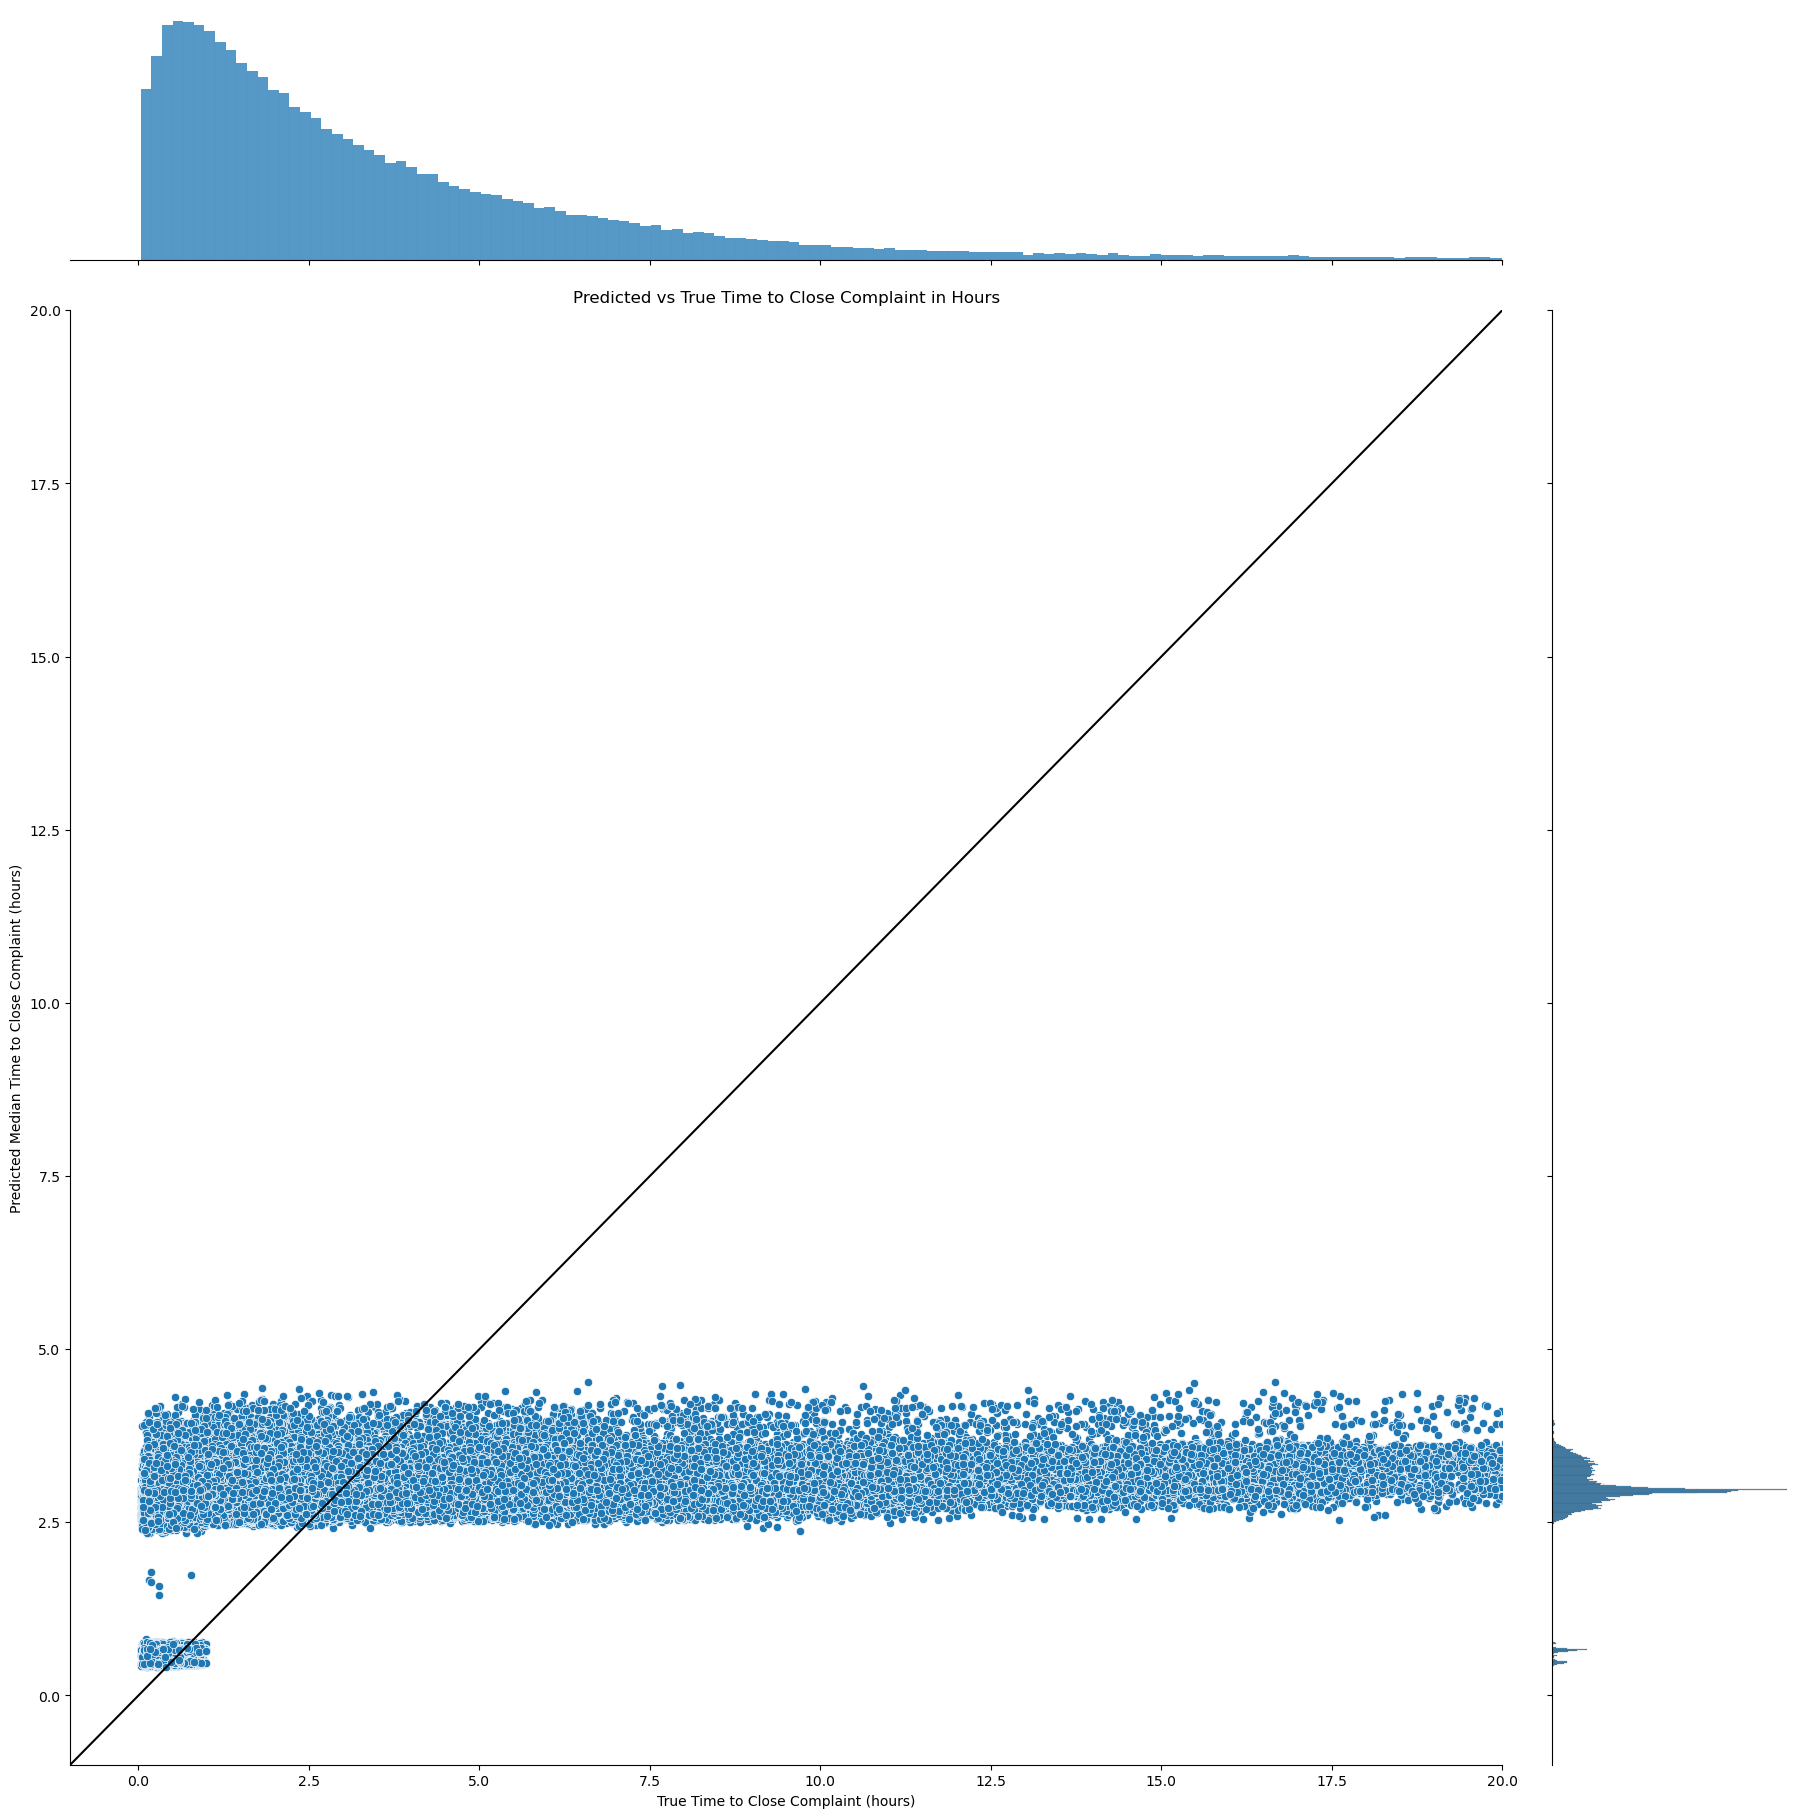

In [22]:
# Define a color palette for different complaint types
palette = sns.color_palette("husl", len(df['complaint_type'].unique()))

# Create a scatter plot with Seaborn
jg = sns.jointplot(data=final_df, x='hours_to_complete', y='med_htc',)
ax = jg.ax_joint
# Show the plot
ax.set_ylim(-1, 20)
ax.set_xlim(ax.get_ylim())
plt.plot([-10,100],[-10,100], color='k')
fig = ax.get_figure()
fig.set_size_inches((20,20))
# ax.legend(bbox_to_anchor=[1,0.55])
ax.set_xlabel('True Time to Close Complaint (hours)')
ax.set_ylabel('Predicted Median Time to Close Complaint (hours)')
ax.set_title('Predicted vs True Time to Close Complaint in Hours')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:  6.2min finished
8000it [00:30, 263.27it/s]


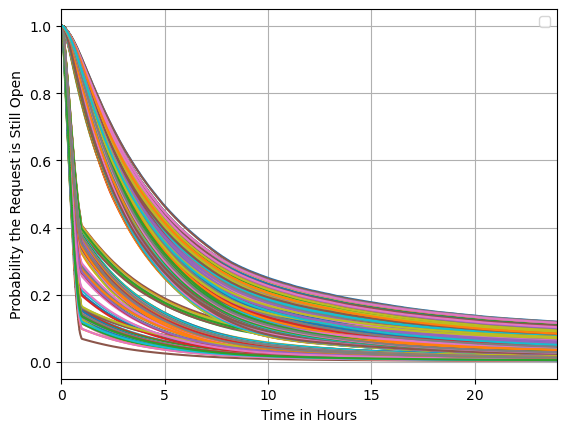

In [23]:
surv = rsf.predict_survival_function(X_test[0:chunk_size], return_array=True)

for i, s in tqdm(enumerate(surv)):
    plt.step(rsf.unique_times_, s, where="post")
plt.ylabel("Probability the Request is Still Open")
plt.xlabel("Time in Hours")
plt.legend([])
plt.xlim((0,24))
plt.grid(True)

In [2]:

times = np.percentile(df["hours_to_complete"], np.linspace(5, 81, 15))

heap = []

for i, col in tqdm(enumerate(X_train.columns)):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, X_test[col], times)
    # ret = concordance_index_ipcw(y_train, y_test, X_test[col], tau=times[-1], )
    in_heap = [mean_auc, col, auc,
            #    ret
               ]
    heapq.heappush(heap, in_heap)

top_10 = heapq.nlargest(10, heap)

NameError: name 'np' is not defined

In [1]:
top_10
assets_path = pathlib.Path("../plots/rsf")
if not assets_path.exists():
    assets_path.mkdir()

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)
for i, (mean_auc, col, auc) in enumerate(top_10):
    ax.plot(times, auc, marker="o", color=f"C{i}", label=col)
    ax.set_xlabel("Hour from Complaint Made")
    ax.set_ylabel("Time-Dependent AUC")
    ax.axhline(mean_auc, color=f"C{i}", linestyle="--")
    plt.legend()
fig.savefig(assets_path/f"{save_name}_TDAUC.png")

NameError: name 'top_10' is not defined

In [ ]:
bottom_10 = heapq.nsmallest(10, heap)
bottom_10

[[0.3513422117196048,
  'open_bo_pr',
  array([0.31313978, 0.32002416, 0.32711117, 0.33981387, 0.34963323,
         0.35801261, 0.3617132 , 0.36510115, 0.36613465, 0.36498914,
         0.36404218, 0.36288589, 0.36030326, 0.35395815, 0.3445588 ])],
 [0.3515002788308468,
  'open_pr',
  array([0.31348254, 0.32026813, 0.32724187, 0.33988468, 0.34972519,
         0.35803465, 0.36179373, 0.3651897 , 0.36622038, 0.36511368,
         0.36420675, 0.36310815, 0.36052073, 0.35419614, 0.34484748])],
 [0.36699487002465603,
  'open_bo_pr_co',
  array([0.26586991, 0.28873815, 0.31089973, 0.33654145, 0.35628791,
         0.3708377 , 0.38018493, 0.38776454, 0.39177439, 0.39379578,
         0.39469947, 0.39652515, 0.39687246, 0.39375885, 0.38801097])],
 [0.3671605397286612,
  'open_pr_co',
  array([0.26636624, 0.28905455, 0.3111034 , 0.33668838, 0.35641547,
         0.37089449, 0.38029307, 0.38786972, 0.39186202, 0.3939044 ,
         0.3948396 , 0.39668297, 0.39702173, 0.39394844, 0.38822261])],
 [0.473

In [ ]:
times = np.arange(0, 24, 7)
cph_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train[:5000], y_test[:5000], cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("time-dependent AUC")
plt.grid(True)

: 

In [ ]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=hyper.seed, max_samples=0.01)

imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)
imp_df.loc[(imp_df['importances_mean'] != 0)]


In [36]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")


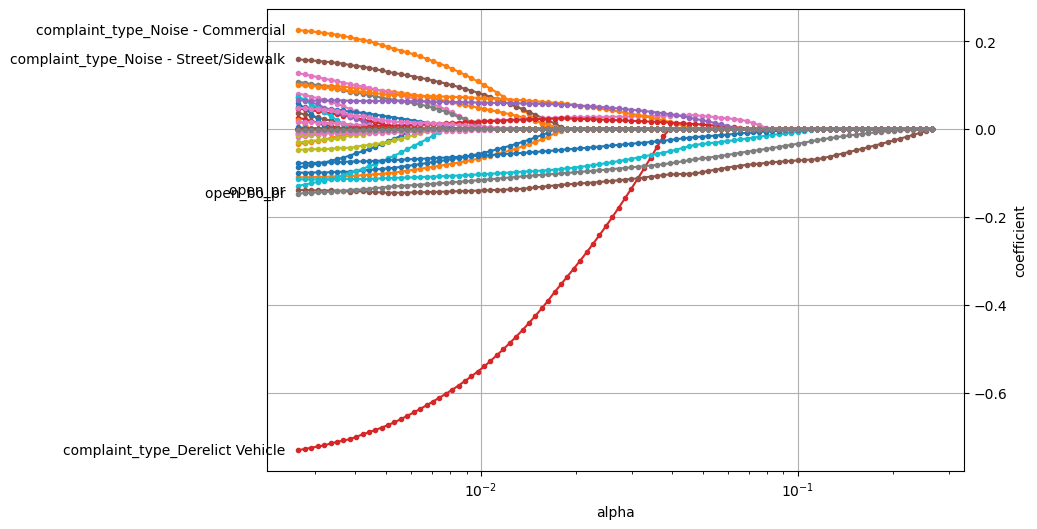

In [38]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=X_train.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [ ]:
times = np.arange(0, 24, 7)
cph_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)